In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.autograd as autograd
import numpy
from torch.optim import Adam
import tqdm

from generate_data import *
from network_class import *
from utils import *
device = 'cuda:3' #@param ['cuda', 'cpu'] {'type':'string'}
tspan=[0,1]
d=1
nt=16
h=(tspan[1]-tspan[0])/nt


In [228]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def Gaussian_1d(x,mu=0,sigma=1):
    return 1/(math.sqrt(2*math.pi*sigma**2))*torch.exp(-(x-mu)**2/2/sigma**2)

def grad_log_Gaussian(x):
    return -x

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    dx = net(x,t)
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    f=net(x, t).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True)[0]
        # torch.autograd.functional.jacobian
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)

    
    #精确计算divergence_f
    # for i in range(d):
    #     grad = autograd.grad(f[:,i].sum(), x, create_graph=True)[0]
    #     divergence_f+= grad[:,i]
    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)
    

    # # 近似计算divergence_f
    # v=torch.randn(f.shape).to(device)
    # vf=torch.sum(f*v, dim=1)
    # a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    # divergence_f=torch.sum(a*v, dim=1)

    
    d_log=-divergence_f.reshape(-1,1)

    #calculate jacobbian 
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze().view(-1,1)

    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*(1/2)


    # d_score=torch.zeros(x.shape[0],d).to(device)
    # d_penalty=torch.zeros(x.shape[0],1).to(device)
    return torch.cat((f,d_log,d_score,d_penalty),dim=1)


In [229]:


loaded_state_dict = torch.load('experiment/1d_mix_gaussian.pth')
f_theta = velocity_net(d=1).to(device)
f_theta.load_state_dict(loaded_state_dict)


<All keys matched successfully>

In [230]:
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)
data=data[:10000].to(device)
zFull = torch.zeros(*data.shape , nt+1, device=data.device, dtype=data.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = data
tk=0

for k in  range(nt):
    zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
    tk += h
print(zFull.shape)

torch.Size([10000, 1, 17])


In [231]:
def single_sliced_score_matching(score_net, samples,t):
    samples.requires_grad_(True)
    
    vectors = torch.randn_like(samples)

    grad1 = score_net(samples,t)
    gradv = torch.sum(grad1 * vectors)
    loss1 = torch.sum(grad1 * vectors, dim=-1) ** 2 * 0.5
    grad2 = autograd.grad(gradv, samples, create_graph=True)[0]
    loss2 = torch.sum(vectors * grad2, dim=-1)


    loss = (loss1 + loss2).mean()
    return loss

In [232]:
n_epochs =  150#@param {'type':'integer'}
batch_size =  10000 #@param {'type':'integer'}
lr=1e-2 #@param {'type':'number'}
score_net=velocity_net(d=1).to(device)
optim = Adam(score_net.parameters(), lr=lr)

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    loss=0

    for i in range(nt+1):
        samples=zFull[:,:,i].view(-1,1).detach()
        t=i*h
        loss+=single_sliced_score_matching(score_net, samples , t)

    optim.zero_grad()
    tqdm_epoch.set_description('Loss: {:5f}'.format(loss.detach().cpu() ))
    loss.backward()
    optim.step()
    if (epoch+1) % 50 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])





Loss: -3.551255:  35%|███▍      | 52/150 [00:02<00:05, 19.11it/s]

lr:  0.005


Loss: -7.567622:  68%|██████▊   | 102/150 [00:05<00:02, 19.07it/s]

lr:  0.0025


Loss: -8.143795: 100%|██████████| 150/150 [00:08<00:00, 18.30it/s]

lr:  0.00125


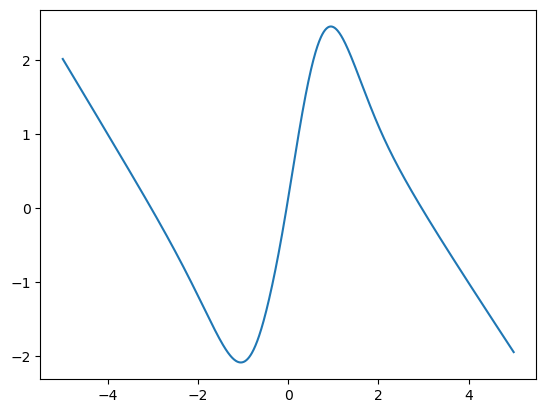

In [233]:
x_space=torch.linspace(-5,5,1000).view(-1,1).to(device)
score_x=score_net(x_space,t=0)
plt.plot(x_space.detach().cpu().numpy(),score_x.detach().cpu().numpy())


torch.Size([10000, 1, 17])


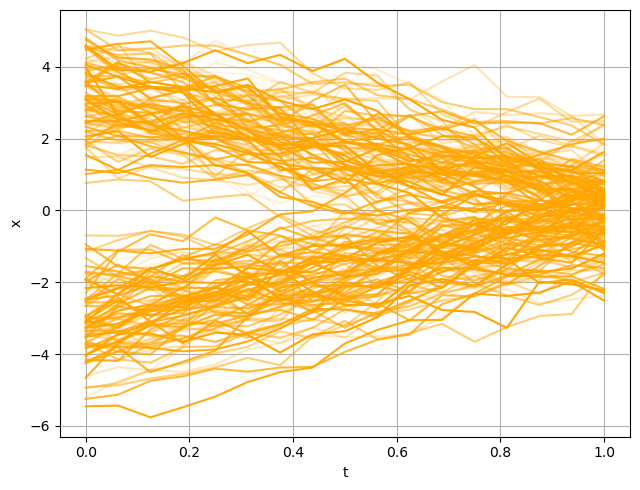

In [234]:
data=torch.load('data/mix_gaussian.pt').reshape(-1,1)
data=data[:10000].to(device)
zFull = torch.zeros(*data.shape , nt+1, device=data.device, dtype=data.dtype) # make tensor of size z.shape[0], z.shape[1], nt
zFull[:,:,0] = data
tk=0

for k in  range(nt):
    zFull[:,:,k+1] = zFull[:,:,k] + (f_theta(zFull[:,:,k],tk)+score_net(zFull[:,:,k],tk))*h+math.sqrt(2*h)*torch.randn(zFull[:,:,k].shape).to(device)
    # zFull[:,:,k+1] = zFull[:,:,k] + f_theta(zFull[:,:,k],tk)*h
    tk += h
print(zFull.shape)
def plot_generate_sequence(zFull, nt):
    fig, axs = plt.subplots(figsize=(6.5, 5))
    
    # 计算每条线的透明度
    num_lines = 200
    alpha_step = 1.0 / num_lines
    
    for i in range(num_lines):
        x = np.linspace(0, 1, nt + 1)
        y = zFull[i, :, :].view(nt + 1, 1).detach().cpu().numpy()
        plt.plot(x, y, color="orange", alpha=alpha_step * (i + 1))
    
    # 显示网格
    plt.grid(True)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()
plot_generate_sequence(zFull, nt)

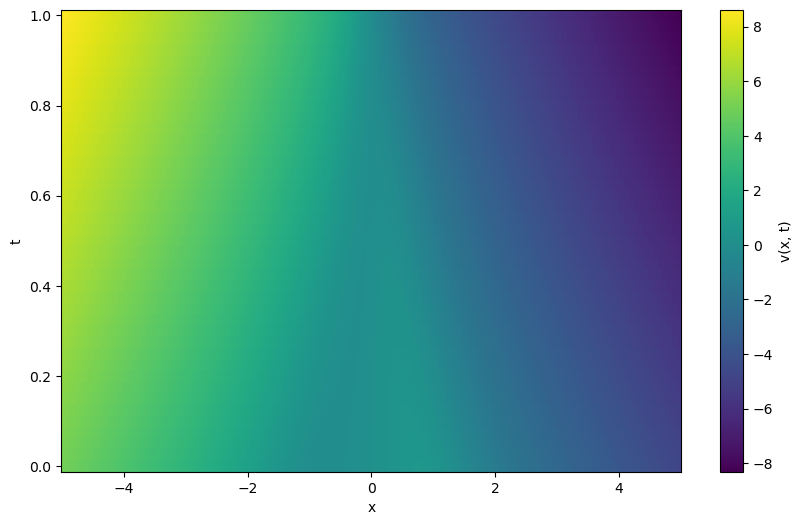

In [235]:
x_space = torch.linspace(-5, 5, 1000).view(-1,1).to(device)
V=torch.zeros(41,1000)
for i in range(41):
    V[i,:]=f_theta(x_space,t=i/40).squeeze()+score_net(x_space,t=i/40).squeeze()

x_space = np.linspace(-5, 5, 1000)
t_space = np.linspace(0, 1, 41)

X, T = np.meshgrid(x_space, t_space)

plt.figure(figsize=(10, 6))
plt.pcolormesh(X,T, V.detach().cpu().numpy(), shading='auto', cmap='viridis')
plt.colorbar(label='v(x, t)')
plt.xlabel('x')
plt.ylabel('t')

plt.show()

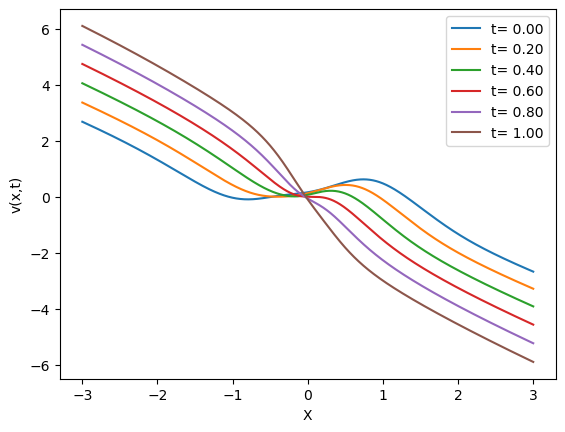

In [236]:
x_space = torch.linspace(-3, 3, 1000).view(-1,1).to(device)
for i in range(0,41,8):
    V=f_theta(x_space,t=i/40)+score_net(x_space,t=i/40)
    plt.plot(x_space.detach().cpu().numpy(),V.detach().cpu().numpy(),label=f"t= {i/40:.2f}")
plt.xlabel("X")
plt.ylabel("v(x,t)")
plt.legend()

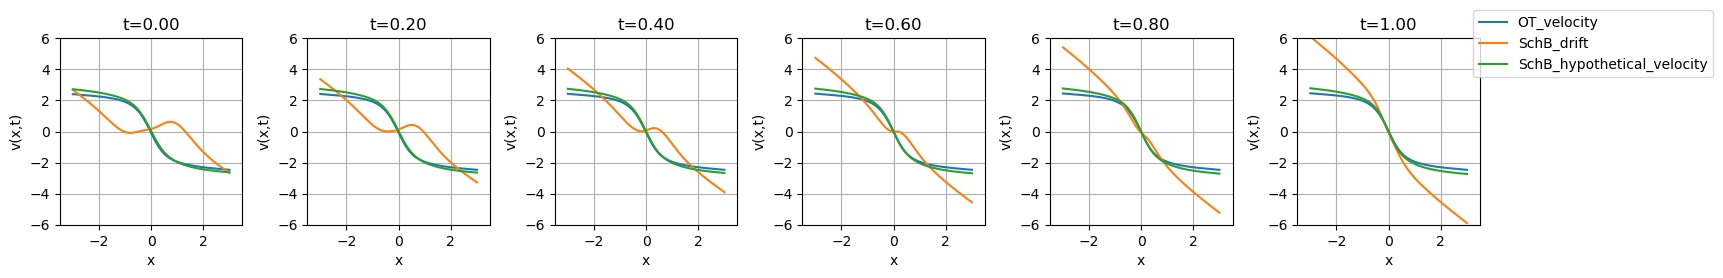

In [237]:
loaded_state_dict = torch.load('experiment/1d_mix_gaussian_ot.pth')
f_theta_ot = velocity_net(d=1).to(device)
f_theta_ot.load_state_dict(loaded_state_dict)

fig, axs = plt.subplots(1, 6, figsize=(15, 2.8))
line_labels=[]
for i in range(6):
    t=i*8/40
    V=f_theta(x_space,t)+score_net(x_space,t)
    F=f_theta(x_space,t)
    V_ot=f_theta_ot(x_space,t)
    label1,=axs[i].plot(x_space.detach().cpu().numpy(),V_ot.detach().cpu().numpy(),label="OT_velocity")
    label2,=axs[i].plot(x_space.detach().cpu().numpy(),V.detach().cpu().numpy(),label="SchB_drift")
    label3,=axs[i].plot(x_space.detach().cpu().numpy(),F.detach().cpu().numpy(),label="SchB_hypothetical_velocity")
    axs[i].set_xlim([-3.5,3.5])
    axs[i].set_ylim([-6,6])
    axs[i].grid()
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("v(x,t)")
    axs[i].set_title(f"t={t:.2f}")
    if i == 5:
        line_labels=[label1,label2,label3]


fig.legend(line_labels,[l.get_label() for l in line_labels],loc="upper right",bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

